**2.155 Term Project**: Neural Network for Long Term Wind Speed Predictions

by Jack Hammer, Luana Rampoletti, and Wilhem Hector

Model is trained to learn the non linear relationship between the atmospheric variables data from four different ERA5 stations and measured MET data.

The trained model is used to infer the wind speed at the MET for the past 20 years.

Imports necessary packages

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from Wind_Data_Format import Dataformatter

:Import data for each point, clean up time/date columns, and split data into desired years

In [10]:
stations = ['Local_Prediction_Data/st1.csv', 'Local_Prediction_Data/st2.csv', 'Local_Prediction_Data/st3.csv', 'Local_Prediction_Data/st4.csv']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_station (station_name, start_date, end_date):
    """
    Take path to a station database, and date range

    Return a formatted dataframe containing data
    for the period specified.

    The timestamps are dropped because only numerical values are
    used to train the model
    """
    station_data = pd.read_csv(station_name, parse_dates=['Date/time [UTC]'])
    formatter = Dataformatter() # Instantiate dataformatter
    era5_data = formatter.format_era5(station_data) # Format ERA5 data
    concurrent_data = formatter.concurrent_data(era5_data, start_date, end_date)
    return concurrent_data.drop(columns=['Timestamp', 'hour'])

def load_met (met_name, start_date, end_date):
    """
    Take path to a MET database, and date range.

    Return a formatted dataframe containing data
    for the period specified.
    """
    station_data = pd.read_csv(met_name, parse_dates=['Timestamp'])
    formatter = Dataformatter() # Instantiate dataformatter
    hourly_data = formatter.hourly_format(station_data) # Convert 10mn ave to hourly data
    adjusted_wind_data = formatter.adjust_wind_met(hourly_data) # Dataframe with adjusted wind speed
    return formatter.concurrent_data(adjusted_wind_data, start_date, end_date)

In [ ]:
# The Wind Data format script takes care of formatting the stations data

# Read the tab-delimited file
# df_point1 = pd.read_csv('/content/ERA5_Point 1.txt', delimiter='\t')
# df_point2 = pd.read_csv('/content/ERA5_Point 2.txt', delimiter='\t')
# df_point3 = pd.read_csv('/content/ERA5_Point 3.txt', delimiter='\t')
# df_point4 = pd.read_csv('/content/ERA5_Point 4.txt', delimiter='\t')

# # Change the time and data to the correct type
# df_point1['Date/time [UTC]'] = pd.to_datetime(df_point1['Date/time [UTC]'])
# df_point2['Date/time [UTC]'] = pd.to_datetime(df_point2['Date/time [UTC]'])
# df_point3['Date/time [UTC]'] = pd.to_datetime(df_point3['Date/time [UTC]'])
# df_point4['Date/time [UTC]'] = pd.to_datetime(df_point4['Date/time [UTC]'])

# # Splitting data into training and test
# # Training years MUST be prior to test years
# training_years = [2005, 2006, 2007, 2008]
# test_years = [2011, 2012, 2013, 2014]
# # Training data
# train_1 = df_point1[df_point1['Date/time [UTC]'].dt.year.isin(training_years)]
# train_2 = df_point2[df_point2['Date/time [UTC]'].dt.year.isin(training_years)].drop(columns = "Date/time [UTC]")
# train_3 = df_point3[df_point3['Date/time [UTC]'].dt.year.isin(training_years)].drop(columns = "Date/time [UTC]")
# train_4 = df_point4[df_point4['Date/time [UTC]'].dt.year.isin(training_years)].drop(columns = "Date/time [UTC]")

# # Test Data
# test_1 = df_point1[df_point1['Date/time [UTC]'].dt.year.isin(test_years)]
# test_2 = df_point2[df_point2['Date/time [UTC]'].dt.year.isin(test_years)].drop(columns = "Date/time [UTC]")
# test_3 = df_point3[df_point3['Date/time [UTC]'].dt.year.isin(test_years)].drop(columns = "Date/time [UTC]")
# test_4 = df_point4[df_point4['Date/time [UTC]'].dt.year.isin(test_years)].drop(columns = "Date/time [UTC]")

FileNotFoundError: [Errno 2] No such file or directory: '/content/ERA5_Point 1.txt'

Remove point 1 wind speed so we can train a model to predict it

In [11]:
# Construct dictionary to store concurrent station data
stations_data = {}
for ix , station in enumerate (stations):
    stations_data[ix] = load_station(station, '2023-05-03 00:00:00', '2024-03-31 23:00:00')

# Measured wind speed that we are trying to predict
met_data = load_met('Mast_8031.csv', '2023-05-03 00:00:00', '2024-03-31 23:00:00')
y = met_data['adjusted_wind_speed_59.1'].values

print(f"Y is {y.shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'Mast_8031.csv'

Concat the rest of the train data to make one big df, change datetime data so we have year, month, day, hour columns

In [ ]:
# Concat all data to one df
train_data_total = pd.concat([stations_data[0], stations_data[1], stations_data[2], stations_data[3]], axis=1)

# Get all DateTime Info
# time_data = pd.to_datetime(train_data_total['Date/time [UTC]'])
# # Extract useful date features
# X_time_features = pd.DataFrame({
#     "year": time_data.dt.year,
#     "month": time_data.dt.month,
#     "day_of_year": time_data.dt.dayofyear,
#     "day_of_week": time_data.dt.weekday,  # 0=Monday, 6=Sunday
#     "hour": time_data.dt.hour,
#     "minute": time_data.dt.minute})
# # Add all these columns to our df and remove the DateTime values
# train_data_total = pd.concat([train_data_total, X_time_features], axis=1)
# train_data_total = train_data_total.drop(columns=['Date/time [UTC]'])

# Checking for the shape fo the new data
print(f"Data is {train_data_total.shape}")

Data is (8016, 16)


One last step of data clean before NN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize the data
scaler_X = MinMaxScaler() # Instantiate standardization
scaler_y = MinMaxScaler()

# Convert DataFrame to NumPy for preprocessing
X_scaled = scaler_X.fit_transform(train_data_total)  # Normalizing every value between 0 and 1
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Create train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train = X_scaled[0:int(.8 * len(X_scaled))]
y_train = y_scaled[0:int(.8 * len(X_scaled))]
X_test = X_scaled[int(.8 * len(X_scaled)):]
y_test = y_scaled[int(.8 * len(X_scaled)):]

print(f"X_train is {X_train.shape}")
print(f"y_train is {y_train.shape}")
print(f"X_test is {X_test.shape}")
print(f"y_test is {y_test.shape}")

# Convert to PyTorch tensors
# X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
# y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# X_train = X_tensor
# y_train = y_tensor

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False) # Adjust batch size as needed
test_loader = DataLoader(test_dataset, batch_size=150, shuffle=True)

X_train is (6412, 16)
y_train is (6412,)
X_test is (1604, 16)
y_test is (1604,)


Lets set up the NN

In [ ]:
# Define the Neural Network
class WindSpeedPredictor(nn.Module):
    def __init__(self):
        super(WindSpeedPredictor, self).__init__()
        # Define Conv1D layers
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32, 1)  # Fully connected layer for regression output

    def forward(self, x):
        # Ensure input is 3D: [batch_size, sequence_length, num_features]
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence length of 1: [batch_size, features] -> [batch_size, 1, features]

        # Fix input shape for Conv1D: [batch_size, num_features, sequence_length]
        x = x.permute(0, 2, 1)  # Swap dimensions

        # Apply Conv1D layers with ReLU activations
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        # Global average pooling (reduce sequence dimension)
        x = torch.mean(x, dim=2)  # Shape: [batch_size, out_channels]

        # Fully connected layer
        x = self.fc(x)  # Final output: [batch_size, 1]
        return x


# ALTERNATE MODEL; Radial Basis Functional Network
class RBFLayer(nn.Module):
    """
    Radial basis layer that transforms the input features
    into a higher-dimensional space using a Gaussian function
    to capture the nonlinear relationship between the input features.
    """
    def __init__(self, in_features, out_features, centers_init=None):
        super(RBFLayer, self).__init__()
        self.in_features = in_features # Number of input features
        self.out_features = out_features # Store RFB (hidden) units

        if centers_init is None: # Initialize centers random if none are provided
            self.centers = nn.Parameter(torch.randn(out_features, in_features)) # Centers of RFB units
        else:
            self.centers = nn.Parameter(centers_init)
        # Logarithm of sigma (spread of the Gaussian function)
        self.log_sigma = nn.Parameter(torch.zeros(out_features))

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features) # Expanded size of the input. Has to match the centers'
        x = input.unsqueeze(1).expand(size) # Add additional dimension to fit expected size
        c = self.centers.unsqueeze(0).expand(size) # Expand the tensor to the expected size
        distances = (x - c).pow(2).sum(-1) # Squared Euclidean distances between input and centers
        activations = torch.exp(-distances / (2 * self.log_sigma.exp().pow(2))) # Apply Gaussian function
        return activations

# Define the neural network architecture
class WindSpeedNN(nn.Module):
    """
    Radial basis functional network that takes a multi dimensional input,
    a number of RBF units (hidden_features), and 1 dimensional output
    """
    def __init__(self, in_features, hidden_features, out_features, centers_init=None):
        super(WindSpeedNN, self).__init__()
        self.rbf = RBFLayer(in_features, hidden_features, centers_init)
        # Linear layer to combine these transformed features
        self.linear = nn.Linear(hidden_features, out_features)

    def forward(self, input):
        x = self.rbf(input)
        x = self.linear(x)
        return x

# Initialize RBF centers using K-means
n_centers = 80
kmeans = KMeans(n_clusters=n_centers, random_state=0).fit(X_scaled) # Central pointa of clusters in the data
centers_initial = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32) # Define intial centers

Training the Model

In [ ]:
# Instantiate the model
# model = WindSpeedPredictor()
model = WindSpeedNN(in_features=16, hidden_features=80, out_features=1, centers_init=centers_initial ).to(device)  # 80 hidden features
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Early stopping criteria
best_test_loss = float('inf')
early_stopping_patience = 10
no_improvement = 0 # Counter for when test loss increases

# Training Loop
num_epochs = 200
losses = []
test_losses = [] # List to store test losses

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 # Measure of the loss after each training
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() # Clean previous grad
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch) # Calculate loss
        loss.backward() # Back propagation to update weights
        optimizer.step() # Parameter update, using the gradient
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader) # How model improves after each sweep
    losses.append(epoch_loss) # For plotting
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Validation the network
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for input_test, targets_test in test_loader:
            input_test, targets_test = input_test.to(device), targets_test.to(device)
            outputs = model(input_test)
            test_loss = criterion(outputs.squeeze(), targets_test)  # Calculate MSE
            total_test_loss += test_loss.item()
        average_test_loss = total_test_loss / len(test_loader)
        test_losses.append(average_test_loss)
        print(f'Test Loss: {average_test_loss:.4f}')

    # Early stopping check
    if average_test_loss <= best_test_loss:
        best_test_loss = average_test_loss
        no_improvement = 0 # Reset when hit new best
        torch.save(model.state_dict(), 'combined_station_model.pth')  # Save the best model
    else:
        no_improvement += 1

    if no_improvement >= early_stopping_patience:
        print("Early stopping!")
        break

Epoch [1/200], Loss: 0.3729
Test Loss: 0.2181
Epoch [2/200], Loss: 0.1731
Test Loss: 0.0947
Epoch [3/200], Loss: 0.0772
Test Loss: 0.0460
Epoch [4/200], Loss: 0.0401
Test Loss: 0.0321
Epoch [5/200], Loss: 0.0280
Test Loss: 0.0290
Epoch [6/200], Loss: 0.0242
Test Loss: 0.0278
Epoch [7/200], Loss: 0.0225
Test Loss: 0.0268
Epoch [8/200], Loss: 0.0213
Test Loss: 0.0256
Epoch [9/200], Loss: 0.0202
Test Loss: 0.0246
Epoch [10/200], Loss: 0.0193
Test Loss: 0.0233
Epoch [11/200], Loss: 0.0184
Test Loss: 0.0225
Epoch [12/200], Loss: 0.0175
Test Loss: 0.0215
Epoch [13/200], Loss: 0.0168
Test Loss: 0.0205
Epoch [14/200], Loss: 0.0160
Test Loss: 0.0195
Epoch [15/200], Loss: 0.0154
Test Loss: 0.0189
Epoch [16/200], Loss: 0.0148
Test Loss: 0.0182
Epoch [17/200], Loss: 0.0142
Test Loss: 0.0176
Epoch [18/200], Loss: 0.0137
Test Loss: 0.0170
Epoch [19/200], Loss: 0.0133
Test Loss: 0.0164
Epoch [20/200], Loss: 0.0129
Test Loss: 0.0160
Epoch [21/200], Loss: 0.0125
Test Loss: 0.0154
Epoch [22/200], Loss: 

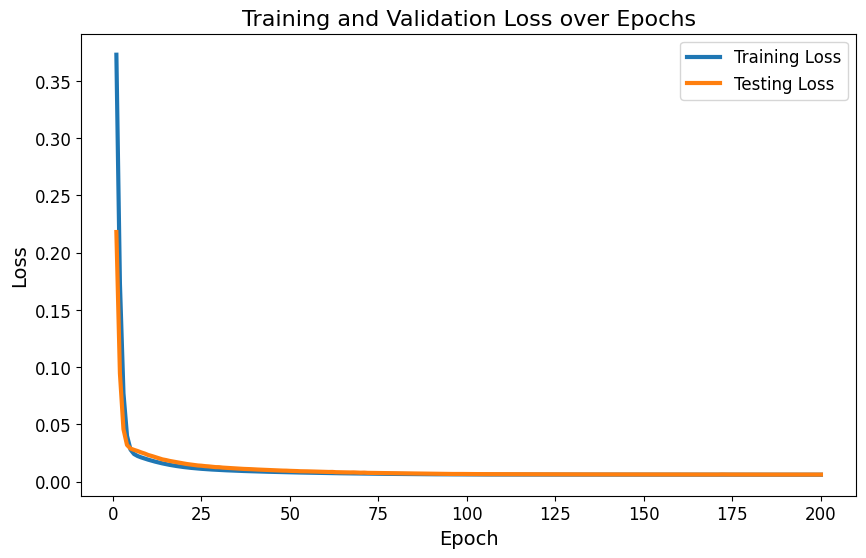

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses) + 1), losses, label='Training Loss', linewidth = 3)
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss', linewidth = 3)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.title('Training and Validation Loss over Epochs', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

Set up test data in similar fashion to before (I think we can process the validation data up there in one go)

In [ ]:
# y_test = test_1['Speed_100m [m/s]']
# test_1 = test_1.drop(columns=['Speed_100m [m/s]'])
# X_test = pd.concat([test_1, test_2, test_3, test_4], axis=1)

# time_data_test = pd.to_datetime(X_test['Date/time [UTC]'])

# # Extract useful date features
# X_time_features_test = pd.DataFrame({
#     "year": time_data_test.dt.year,
#     "month": time_data_test.dt.month,
#     "day_of_year": time_data_test.dt.dayofyear,
#     "day_of_week": time_data_test.dt.weekday,  # 0=Monday, 6=Sunday
#     "hour": time_data_test.dt.hour,
#     "minute": time_data_test.dt.minute})
# # Add all these columns to our df and remove the DateTime values
# X_test = pd.concat([X_test, X_time_features_test], axis=1)
# X_test = X_test.drop(columns=['Date/time [UTC]'])
# # Checking for the shape fo the new data
# print(f"X Data is {X_test.shape}")
# print(f"Y Data is {y_test.shape}")

Here our test data is the month of April 2024

Use trained model to predict the wind speeds for the month of april

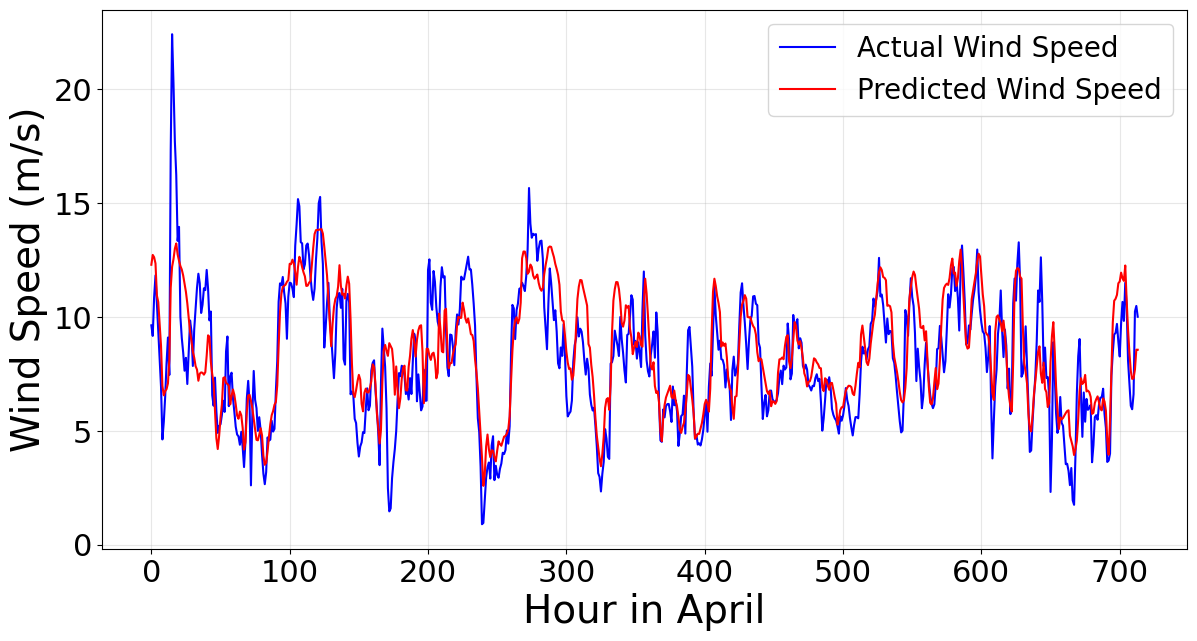

In [ ]:
# Measured wind speed by Radia for the month of april
met_april = load_met('Mast_8031.csv', '2024-04-01 00:00:00', '2024-04-30 17:00:00')
reference_wsp = met_april['adjusted_wind_speed_59.1'].values

# ERA5 stations data for the month of april
validation = {}
for idx , station in enumerate (stations):
    validation[idx] = load_station(station, '2024-04-01 00:00:00', '2024-04-30 17:00:00')

val_dataset = pd.concat([validation[0], validation[1], validation[2], validation[3]], axis=1)
to_predict = scaler_X.transform(val_dataset) # Transform the data
predict_tensor = torch.tensor(to_predict, dtype=torch.float32).to(device)

# Make predictions
model.to(device)
model.eval()
with torch.no_grad():
    predictions = model(predict_tensor).numpy()

predicted_wind_speeds = scaler_y.inverse_transform(predictions)
# reference_wsp = scaler_y.inverse_transform(y_test.reshape(-1,1))
test_hours = np.arange(len(reference_wsp))

# Plot the actual and predicted wind speeds
plt.figure(figsize=(14, 7))
plt.plot( reference_wsp, label='Actual Wind Speed', color='blue')
plt.plot(predicted_wind_speeds, label='Predicted Wind Speed', color='red')
plt.xlabel('Hour in April', fontsize = 28)
plt.ylabel('Wind Speed (m/s)', fontsize = 28)
# plt.title('Actual vs Predicted Wind Speed for April 2024', fontsize = 18)
plt.legend(fontsize = 20)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('ActVSPred.png')
plt.show()

Dont know if the below is necessary given that we dont have years of testing anymore

In [ ]:
# Convert DataFrame to NumPy for preprocessing
X = X_test.values  # Shape: (35064, 21)
y = np.array(y_test.values).reshape(-1,1)    # Shape: (35064, 1)

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

X_test = X_tensor
y_test = y_tensor

# Create PyTorch datasets and loaders
test_dataset = TensorDataset(X_test, y_test)

test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)


# Evaluation Loop
model.eval()  # Set model to evaluation mode
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation for evaluation
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

print(f"Test Loss (Mean Squared Error): {test_loss/len(test_loader):.4f}")

# Predictions
with torch.no_grad():
    predictions = model(X_test[:5])  # Predict for first 5 test samples
    print("Predictions (scaled):", predictions.numpy())

# Optionally inverse-transform the scaled predictions back to the original scale
original_predictions = scaler_y.inverse_transform(predictions.numpy())
print("Predictions (original scale):", original_predictions)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

Graphing error for the test month

MSE: 3.0001365747657616
MAPE: 0.18463040413189868
RMSE: 1.7320902328590626
R2: 0.6308557010995326
Mean Ratio: 1.0012442386826983
Check data is (714, 1)
Real data is (714, 1)


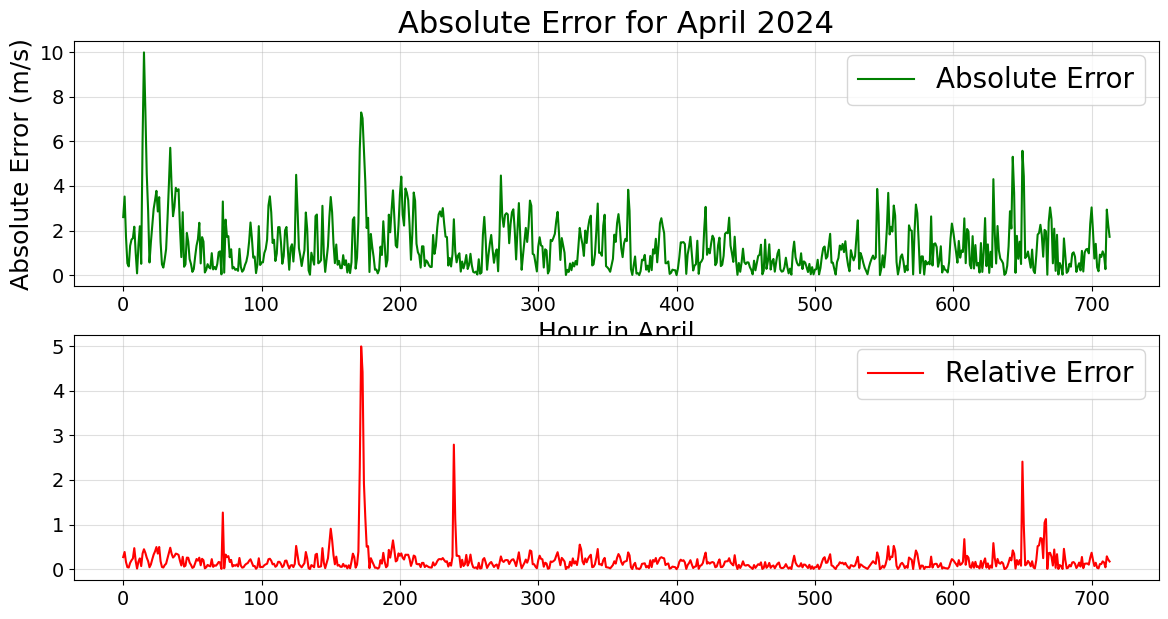

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

mse_pred = mean_squared_error(reference_wsp.squeeze(), predicted_wind_speeds)
print(f"MSE: {mse_pred}")

mape_pred = mean_absolute_percentage_error(reference_wsp.squeeze(), predicted_wind_speeds)
print(f"MAPE: {mape_pred}")

rmse_pred = np.sqrt(mean_squared_error(reference_wsp.squeeze(), predicted_wind_speeds))
print(f"RMSE: {rmse_pred}")

r2_pred = r2_score(reference_wsp.squeeze(), predicted_wind_speeds)
print(f"R2: {r2_pred}")

mean_ratio = np.mean(predicted_wind_speeds)/np.mean(reference_wsp)
print(f"Mean Ratio: {mean_ratio}")


check_data = predicted_wind_speeds
real_data = reference_wsp.squeeze().reshape(-1,1)

print(f"Check data is {check_data.shape}")
print(f"Real data is {real_data.reshape(-1,1).shape}")
abs_error = np.abs(check_data - real_data)

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(abs_error, label='Absolute Error', color='green')
plt.xlabel('Hour in April', fontsize = 18)
plt.ylabel('Absolute Error (m/s)', fontsize = 18)
plt.title('Absolute Error for April 2024', fontsize = 22)

plt.legend(fontsize = 20)
plt.grid(True, alpha=0.4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(2, 1, 2)
relative_error = abs_error/real_data
plt.plot(relative_error, label='Relative Error', color='red')

plt.legend(fontsize = 20)
plt.grid(True, alpha=0.4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Additional Metrics (Scikit learn already has built in module that calculates certain of the metrics you have up there. You might want to verify your formulas against what they have)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
mse_pred = mean_squared_error (reference_wsp.squeeze(), predicted_wind_speeds)
mape_pred = mean_absolute_percentage_error(reference_wsp.squeeze(), predicted_wind_speeds)
rmse_pred = np.sqrt(mean_squared_error(reference_wsp.squeeze(), predicted_wind_speeds))
r2_pred = r2_score(reference_wsp.squeeze(), predicted_wind_speeds)
mean_ratio = np.mean(predicted_wind_speeds)/np.mean(reference_wsp)

[mse_pred, mape_pred, rmse_pred, r2_pred, mean_ratio]

[2.6707017111555187,
 0.19227393389994396,
 1.6342281698574157,
 0.6713901896903625,
 1.0332255865928581]

Pair plotting

In [ ]:
d = load_station('st1.csv', '2023-01-01 00:00:00', '2023-02-1 23:00:00')
print(d)


threshold = np.mean(d['Speed_100m [m/s]'])  # Calculate the threshold value
def categorize_feature(value):
    if value < threshold:
        return 'Below Mean Wind Speed'
    else:
        return 'Above Mean Wind Speed'

d['speed_category'] = d['Speed_100m [m/s]'].apply(categorize_feature)
# Rename the column 'old_name' to 'new_name'
dict = {
    'Speed_100m [m/s]': 'WS [m/s]',
    'Temperature_2m [degrees C]' : 'Temp [°C]',
    'RH 58m [%]' : 'RH [%]',
    'Direction_100m [degrees]' : "Dir [°]",
    'Pressure_0m [kPa]' : "Pres [kPa]"
}
d.rename(columns=dict, inplace=True)

print(d.head())

        Speed_100m [m/s]  Direction_100m [degrees]  \
385711              9.84                     237.1   
385712              9.40                     239.6   
385713              8.91                     243.2   
385714              9.36                     247.0   
385715              9.06                     251.4   
...                  ...                       ...   
386474              2.07                      42.2   
386475              2.23                      81.4   
386476              1.75                      74.7   
386477              1.84                      65.0   
386478              2.03                      96.4   

        Temperature_2m [degrees C]  Pressure_0m [kPa]  
385711                        13.3               91.5  
385712                        13.0               91.5  
385713                        11.7               91.5  
385714                         9.5               91.5  
385715                         9.5               91.5  
...            

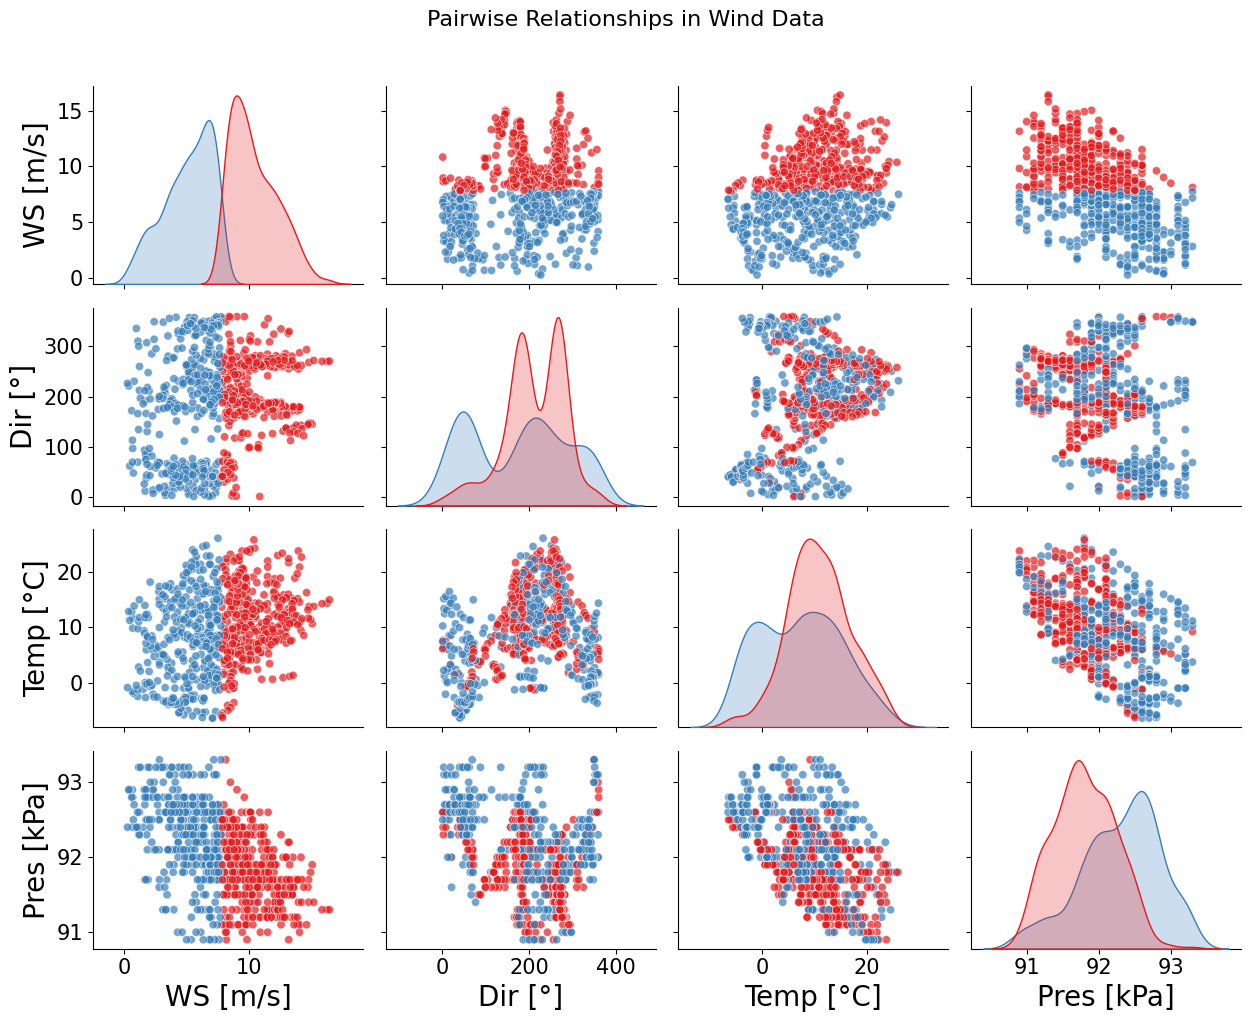

In [ ]:
import seaborn as sns
g = sns.pairplot(d,
                 hue = 'speed_category',  # Color by speed category
                 palette = 'Set1',
                 diag_kind='kde',  # Use KDE instead of histograms
                 markers= 'o',
                 height=2.5,  # Size of the plots
                 plot_kws={'alpha': 0.7}  # Set transparency to improve readability
                )


# Customize title and layout
g.fig.suptitle('Pairwise Relationships in Wind Data', fontsize=16, y=1.02)
plt.tight_layout()  # Adjust spacing

# More precise font configuration
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
})
g._legend.remove()
# Save with additional metadata
plt.savefig('pairplot_Wind_data.png',
            dpi=300,
            bbox_inches='tight',  # Trim unnecessary whitespace
            metadata={'Author': 'Your Name', 'Description': 'Wind Data Analysis'}
)
plt.show()